
<h1 align="center">1. Introduction</h1>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Dans ce notebook, j’explore et je nettoie les données textuelles du challenge <b>Rakuten France Product Data Classification</b>.
Mon objectif principal est de préparer un corpus textuel propre, cohérent et directement exploitable pour la vectorisation (TF-IDF, embeddings, modèles ML/DL).


Mon objectif est de :

- analyser la structure et la qualité des colonnes textuelles (<code>designation</code>, <code>description</code>) ;
- identifier les valeurs manquantes et les incohérences ;
- nettoyer, normaliser et homogénéiser les textes ;
- comprendre la distribution lexicale globale et par catégorie ;
- construire un pré-traitement complet, reproductible et exploitable ;
- produire un dataset textuel propre, prêt pour la modélisation.

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">
⚠️ Ce notebook est <b>exclusivement dédié au traitement du texte</b>.  
L’analyse des images sera réalisée séparément dans un autre notebook.
</div>

In [50]:
import regex as reg 
import unicodedata  
import os, re, json, html, base64
import numpy as np
import pandas as pd
from pathlib import Path
from ftfy import fix_text
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from nltk.corpus import stopwords
import nltk
from collections import Counter

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
<h2 align="center">2. Chargement des données et aprçu initial</h2>

- <code>X_train_update.csv</code> contenant les textes bruts ;
- <code>Y_train_CVw08PX.csv</code> contenant les labels <code>prdtypecode</code>.


In [51]:
DATA_DIR = Path("/workspace/data")
IMG_DIR = Path("/workspace/data/images/image_train")
X_train = pd.read_csv(DATA_DIR/"X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR/"Y_train_CVw08PX.csv", index_col=0)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Afficher quelques lignes avec `head()` et j’utilise `info()` pour vérifier :

- le nombre de lignes et de colonnes ;


In [52]:
X_train.info()
print("="*40)
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- Sélectionne 5 exemples (lignes) au hasard dans X_train pour inspection.

In [53]:
#'random_state=42' assure que cet échantillon aléatoire est toujours le même
X_sample = X_train.sample(5, random_state=42)
Y_sample = Y_train.sample(5, random_state=42)
display(X_sample)

,designation,description,productid,imageid
36138,Nk Pro Racing - Jeu En Téléchargement,<strong>À PROPOS DU JEU</strong> <b>NKPro Rac...,1711734527,1100082580
68630,Exit - Tombeau Du Pharaon,"<div class=""rte""><p>EXIT est un jeu qui repren...",2397542298,1139624392
36172,Bricolage Lettres En Mousse D'argent Alphabet ...,Bricolage lettres en mousse d&#39;argent Alpha...,3979577549,1271697301
9830,Nostalgique Fer Blanc Clockwork Chaîne Jouet P...,Nostalgique fer blanc Clockwork chaîne Jouet P...,4197657726,1313204688
28422,Le Courrier De L'unesco Mai 1996 N° 9605 : Le...,NaN,52594358,518749844


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
- Affiche toutes les lignes de X_train qui contiennent au moins une valeur manquante (NaN).

In [54]:

display(X_train[X_train.isnull().any(axis=1)])

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
5,Afrique Contemporaine N° 212 Hiver 2004 - Doss...,NaN,5862738,393356830
6,Christof E: Bildungsprozessen Auf Der Spur,NaN,91920807,907794536
...,...,...,...,...
84898,Patrie Suisse (La) N° 136 Du 07/12/1898 - Alex...,NaN,570634446,1027296807
84900,Mi Libro De Cortar Y Pegar,NaN,85849076,895279629
84911,The Sims [ Import Anglais ],NaN,206719094,941495734
84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617


,prdtypecode,designation,description,imageid,image
0,10,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,1263597046,

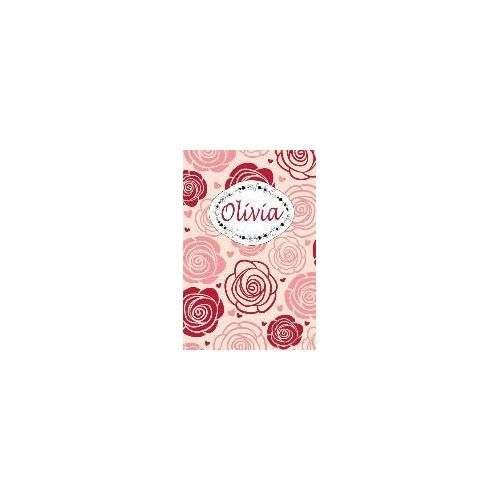

In [55]:
IMG_DIR = Path("/workspace/data/images/image_train")
files = list(IMG_DIR.glob("*.jpg"))
pat = re.compile(r"image_(\d+)_product_(\d+)\.jpg$")
lookup = {}
for p in files:
    m = pat.search(p.name)
    if m:
        lookup[m.group(1)] = p

df["image_path"] = df["imageid"].apply(lambda i: lookup.get(str(int(i))))

S = 256
def img_cell(p, size=S):
    if p is None or not Path(p).exists():
        return ""
    b64 = base64.b64encode(Path(p).read_bytes()).decode("ascii")
    return f'<img src="data:image/jpeg;base64,{b64}" />'

cols = ["prdtypecode","designation","description","imageid","image_path"]
view = df[cols].head(1).copy()
view["image"] = view["image_path"].apply(lambda p: img_cell(p, S))
view = view.drop(columns=["image_path"])

display(HTML(view.to_html(escape=False, index=True)))


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">3. Description manquante</h2>
Objectif : évaluer la disponibilité des descriptions et comprendre quelles catégories sont les plus affectées.
</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
- Analyse des valeurs manquantes dans X_train :
- Affiche un aperçu des lignes avec des NaN, prend un échantillon aléatoire (X et Y),
- calcule le taux de NaN global par colonne, et affiche le taux spécifique pour la colonne 'description'.
- taux manquant de description

In [56]:
no_description = X_train["description"].isna().mean()
print(f"Description manquante: {no_description:.2%}")

Description manquante: 35.09%


In [57]:
no_designation = X_train["designation"].isna().mean()
display(f"Designation manquante: {no_designation:.2%}")

'Designation manquante: 0.00%'

In [58]:
# Fusionne X_train Y_train dans un seul DataFrame 'df' en se basant sur leurs index.
df = X_train.join(Y_train, how="inner")

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- Calculer la proportion de descriptions manquantes par catégorie ('prdtypecode')

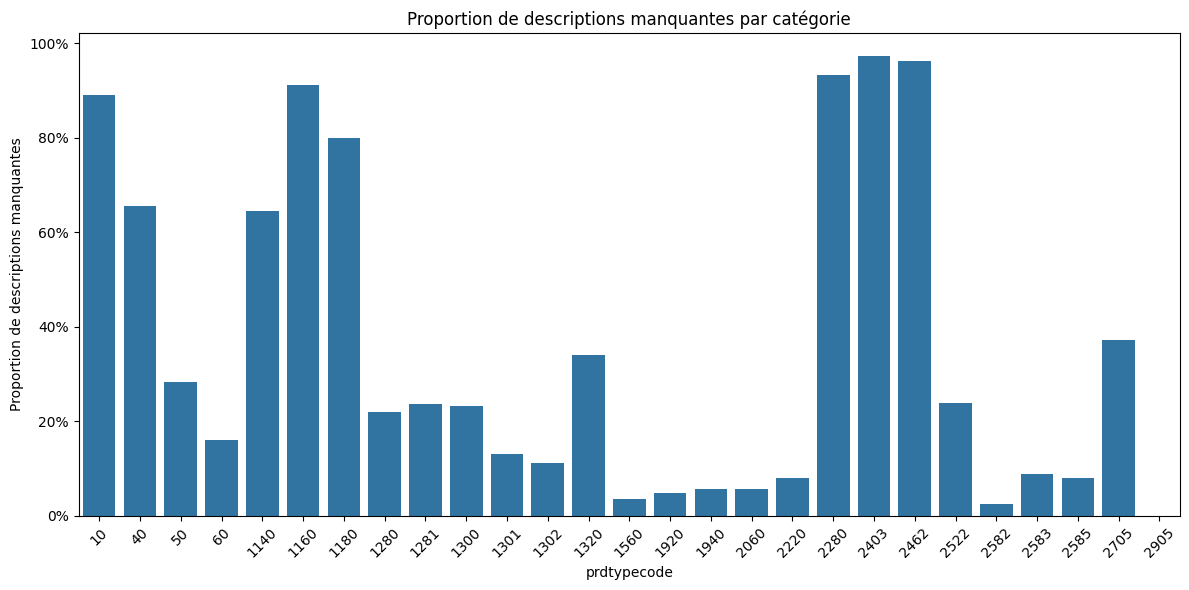

In [59]:

missing_by_cat = (
    df.assign(description_isna=df["description"].isna())  # Ajoute une colonne True/False si la description est NaN
      .groupby("prdtypecode")["description_isna"]         # Regroupe par catégorie de produit
      .mean()                                             # Calcule le taux moyen de NaN (True=1, False=0)
      .reset_index(name="missing_ratio")                  # Convertit le résultat en DataFrame
)

# 2. Trier les catégories par taux de descriptions manquantes
missing_by_cat = missing_by_cat.sort_values("missing_ratio", ascending=False)

# Créer la figure pour le graphique
plt.figure(figsize=(12, 6))

# Créer le graphique en barres
sns.barplot(
    data=missing_by_cat,
    x="prdtypecode",          
    y="missing_ratio"         
)

# 3. Formater l'axe Y en pourcentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title("Proportion de descriptions manquantes par catégorie")
plt.xlabel("prdtypecode")
plt.ylabel("Proportion de descriptions manquantes")

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()         

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">4. Fusionner la designation et la description</h2>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

Étant donné que la colonne descriptions présente plus de $35\%$ de valeurs manquantes, il est décidé de fusionner les deux colonnes afin de faciliter l'analyse et le nettoyage du texte.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- Préparer un aperçu global en HTML avec image :
- scanner les fichiers images, les associe aux 'imageid' du DataFrame via une 'lookup' (dictionnaire),
- convertir les images en HTML pour les afficher dans la table.

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- fusionner la designation et la description à <code>text</code>

In [60]:
df["text"] = (df["designation"] + " " + df["description"])

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">5. Analyser les mots les plus fréquents</h2>

<div style="background:#fff3cd; padding:12px; border-left:6px solid #ffdd57; border-radius:4px">

Le modèle TF-IDF qui sera utilisé pour ce projet a pour caractéristique principale d'augmenter le poids des termes uniques et localement importants dans un document, tout en diminuant celui des mots qui sont universellement fréquents dans l'ensemble du corpus.

C'est pourquoi j'ai décidé de commencer par le nettoyage des mots à haute fréquence comme stratégie centrale : Dans le modèle TF-IDF, les termes trop fréquents mais non discriminants (c'est-à-dire le bruit) diluent les signaux véritablement précieux. Il est donc nécessaire d'identifier et de neutraliser ces mots interférents de haute fréquence en amont, afin d'améliorer la capacité du modèle à identifier les caractéristiques pertinentes.

</div>
    

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- Identifier et afficher les mots les plus fréquents dans le texte original.

In [61]:
top_n = 40

def get_word_freq(series, top_n):
    all_words = []
    for text in series:
        if isinstance(text, str):
            all_words.extend(text.split())
    return Counter(all_words).most_common(top_n)

freq_before = get_word_freq(df["text"],       top_n=top_n)

print("=== Top words BEFORE cleaning ===")
print(freq_before)

=== Top words BEFORE cleaning ===
[('de', 372594), ('et', 145416), ('la', 136099), ('à', 111573), ('pour', 84362), ('en', 78539), (':', 76973), ('x', 69487), ('le', 69100), ('les', 66721), ('-', 54565), ('des', 51756), ('un', 46013), ('est', 44531), ('une', 41333), ('du', 39398), ('vous', 38690), ('avec', 38553), ('/>', 33990), ('1', 32297), ('votre', 31283), ('/', 28779), ('De', 27962), ('<br', 26820), ('dans', 25452), ('ou', 24846), ('sur', 24438), ('cm', 22887), ('pas', 21695), ('plus', 20084), ('peut', 20084), ('que', 18200), ('2', 17713), ('au', 17345), ('Le', 16969), ('haute', 15897), ('piscine', 15643), ('La', 15386), ('être', 15259), ('*', 15024)]


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Il est évident que, parmi ces mots les plus fréquents, la majorité sont des particules, des mots vides (mots grammaticaux) et autres termes sans signification en français, ainsi que des symboles de balisage HTML.
<br></br>
Mais il est également évident que certains mots sont très importants pour la classification, comme "piscine". Pour le prouver, examinons la fréquence d'apparition de "piscine" dans les différentes catégories, comme illustré ci-dessous :
</div>

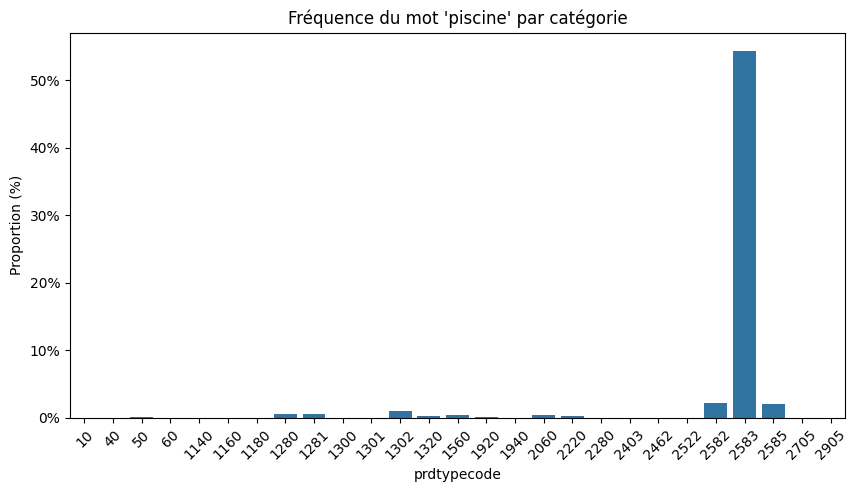

In [62]:
def plot_keyword_per_category(df, keyword, text_col="text"):
    df["contains_word"] = df[text_col].str.contains(fr"\b{keyword}\b", na=False)
    freq = df.groupby("prdtypecode")["contains_word"].mean().reset_index()
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=freq, x="prdtypecode", y="contains_word")
    plt.title(f"Fréquence du mot '{keyword}' par catégorie")
    plt.ylabel("Proportion (%)")
    plt.xlabel("prdtypecode")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.xticks(rotation=45)
    plt.show()

plot_keyword_per_category(df, "piscine")

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2 align="center">6. Nettoyage du texte</h2>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">6.1 Couvre la suppression des balises HTML, des symboles isolés, et des espaces excédentaires.</h3>

In [63]:
def nettoyer_texte(text):
    if pd.isna(text): return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)          # Supprime HTML
    s = html.unescape(s)                     # Décode entités HTML
    s = fix_text(s)                          # Corrige texte cassé
    s = unicodedata.normalize("NFC", s)      # Normalise Unicode
    s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)  # Supprime points non numériques
    s = reg.sub(r"(?<!\S)-(?!\S)", " ", s)   # Supprime tirets isolés
    s = reg.sub(r"(?<!\S):(?!\S)", " ", s)   # Supprime deux-points isolés
    s = reg.sub(r"(?<!\S)·(?!\S)", " ", s)   # Supprime points médians isolés
    s = reg.sub(r"(?<!\S)/(?!\S)", " ", s)
    s = reg.sub(r"(?<!\S)\+(?!\S)", " ", s)
    s = s.replace("////", " ")
    s = s.lower()
    s = reg.sub(r"\s+", " ", s).strip()     # Nettoie espaces et casse
    return s


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">6.2 Nettoie et affiche le texte pour comparaison.</h3>

In [64]:
index_to_check = 36138
original_text = df.loc[index_to_check, 'text']
cleaned_text = nettoyer_texte(original_text)

print(f"--- Index {index_to_check} [text original] ---")
print(original_text)
print("\n" + "="*40 + "\n")
print(f"--- Index {index_to_check} [text cleaned] ---")
print(cleaned_text)


--- Index 36138 [text original] ---
Nk Pro Racing - Jeu En Téléchargement <strong>À PROPOS DU JEU</strong>  <b>NKPro Racing</b> dispose d&#39;un moteur physique de pointe. Cette expérience de conduite hyperréaliste prend également en compte les conditions météorologiques comme la simulation de l&#39;aquaplaning pour des courses plus vraies que nature. <br /><br /> Vivez une expérience de conduite hyperréaliste avec les changements de météo qui affectent les conditions de course les cockpits interactifs et les écrans de télémétrie qui fournissent les données précises et les analyses des courses. Retrouvez 9 catégories de voitures prototypes (monoplaces et GT) un mode multijoueur jusqu&#39;à 15 un éditeur de circuits qui permet à la communauté en ligne de créer et de télécharger leurs propres pistes? NKPro Racing est le simulateur de course ULTIME! <br /><br /><br /> <strong>CARACTÉRISTIQUES</strong>  <ul><li>jeu de course ultra-réaliste</li><li><br /> </li><li>Conduite sous la pluie</li

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">6.2 Préparation du Vocabulaire avec les Mots Vides Français et Anglais</h3>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">
    
- Pour les éléments linguistiques tels que les articles, les prépositions, les conjonctions et les pronoms en français et en anglais, le NLTK (Natural Language Toolkit) propose une bibliothèque de mots vides (stopwords) qui peut facilement nous aider à filtrer ces termes. Je utilise cette bibliothèque pour nettoyer ces éléments linguistiques non significatifs :

In [65]:
nltk.download('stopwords')
NLTK_STOPS = set(stopwords.words("french")) | set(stopwords.words("english"))

def nltk_stopwords(text: str, stopwords_set=None):
    if stopwords_set is None:
        stopwords_set = set()
    if not isinstance(text, str):
        return []

    tokens = []
    for w in text.split():
        w = w.lower()
        if w in stopwords_set:
            continue
        tokens.append(w)
    return tokens
    

def get_word_freq_with_nltk_stopwords(series, stopwords_set=None):
    all_tokens = []
    for text in series:
        all_tokens.extend(nltk_stopwords(text, stopwords_set))
    return Counter(all_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/appuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3 align="center">6.3 Fonction pour Identifier les Bigrams et Trigrams Dominants</h3>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- L'extraction des N-grams via le CountVectorizer permet d'identifier les séquences de mots ou expressions fréquemment co-occurrentes qui portent un sens spécifique dans le corpus. Cette analyse est cruciale pour révéler des thèmes, des relations contextuelles ou des motifs linguistiques que les mots individuels ne peuvent pas montrer, offrant ainsi des informations précieuses pour la modélisation et l'ingénierie des caractéristiques du texte.

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=5)  
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    df = pd.DataFrame(freqs, columns=["ngram", "count"])
    return df.sort_values(by="count", ascending=False).head(top_n)

corpus = df["text"].astype(str).tolist()

print("Top 10 bigrams:")
display(get_top_ngrams(corpus, ngram_range=(2,2), top_n=10))

print("\nTop 10 trigrams:")
display(get_top_ngrams(corpus, ngram_range=(3,3), top_n=10))

Top 10 bigrams:


,ngram,count
88366,li li,45585
45103,de la,45475
43402,de 39,24321
26089,br br,20373
6505,39 eau,15105
62022,et de,15086
44980,de haute,10844
6817,39 il,10497
115765,pour les,10240
73922,haute qualité,10152



Top 10 trigrams:


,ngram,count
8186,39 il vous,9313
91975,il vous plaît,9270
51631,de haute qualité,8965
70637,en raison de,6443
109050,li li strong,5371
102969,le forfait comprend,4889
814,100 tout neuf,4636
167031,tout neuf et,4396
75844,et de haute,4232
146497,raison de la,4142


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- Établir manuellement une liste d'expressions fréquentes, qui sera enrichie et ajustée de manière itérative lors des phases de nettoyage suivantes.

In [67]:
# boilerplate phrase list
BOILERPLATE_PHRASES = ["de haute qualite", "haute qualite", "il vous plait", "vous plait", "vous plait permettre", "peut etre", "peut etre legerement", "peut etre utilise", "etre legerement different",
    "raison de la", "en raison", "en raison de", "raison de", "la couleur reelle", "couleur reelle de", "couleur reelle", "la couleur et", "la couleur de", "la mesure", "la mesure manuelle",
    "de la mesure", "la difference", "de la difference", "la lumiere", "de la lumiere", "ne pas", "ne pas utiliser", "ne pas refleter", "ne pas reflecter", "ne sont pas", "pas refleter la",
        "pas reflecter la", "plait permettre une", "la marque", "de la marque", "la main", "tout neuf", "100 tout neuf", "neuf et", "neuf et de", "tout neuf et", "forfait comprend",
    "le forfait comprend", "le forfait", "contenu de emballage", "contenu du coffret", "le paquet contient", "de element peut", "element peut etre", "permettre une legere", "duree de vie",
    "different des images", "en fonction de",]

def remove_boilerplate_phrases(s: str) -> str:
    if not s:
        return s
    out = s
    for phrase in BOILERPLATE_PHRASES:
        out = out.replace(phrase, " ")
    return out


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

- tablir une liste personnalisée de mots vides stop words en fonction de la distribution des mots et des expressions dans les différentes catégories.

In [68]:
MY_STOPWORDS: set[str] = {
    "cm", "mm", "kg", "g", "l",
    "qualite", "neuf", "nouveau",
}


In [69]:
def merge_x_dimensions(text):
    if pd.isna(text):
        return ""
    s = str(text)

    # 1) merge numeric triplets: 22 x 11 x 2 → 22x11x2
    s = reg.sub(r"\b(\d+)\s*[xX]\s*(\d+)\s*[xX]\s*(\d+)\b", r"\1x\2x\3", s)

    # 2) merge numeric pairs: 180 x 180 → 180x200
    s = reg.sub(r"\b(\d+)\s*[xX]\s*(\d+)\b", r"\1x\2", s)

    # 3) merge letter triplets: L x H x L → LxHxL
    s = reg.sub(r"\b([LlHh])\s*[xX]\s*([LlHh])\s*[xX]\s*([LlHh])\b", r"\1x\2x\3", s)

    return s

df["text_xmerged"] = df["text"].apply(merge_x_dimensions)